# XAI CODE DEMO

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AIPI-590-XAI/Duke-AI-XAI/blob/dev/interpretable-ml-example-notebooks/kan_interpretability.ipynb)

# Kolmogorov-Arnold Network (KAN)

* Paper: [Liu,et.al., 2024](https://arxiv.org/pdf/2404.19756)
* KANs have no linear weights at all – every weight parameter is replaced by a univariate function parametrized as a spline
* KANs can be intuitively visualized and can easily interact with human users

#### Training a KAN:
1. Randomly initialize parameters of B-splines for each function in each layer
2. Forward pass X through the network
3. Calculate loss wrt ground truth
4. Backpropagation
5. Update B-spline parameters
6. Repeat

#### Code Demo
The original paper authors released [pykan](https://kindxiaoming.github.io/pykan/index.html), a python library for KANs. This demo is based off of the documentation provided in the library, specifically ["Getting Started with KANs"](https://kindxiaoming.github.io/pykan/intro.html#get-started-with-kans)



---






In [1]:
!pip install pykan

In [2]:
from kan import *
import torch

#### Initialize a KAN
* width = [2, 3, 1] - 2D input, 1D output, 5 hidden neurons
* k=3 - use cubic splines
* grid=5 - use 5 grid intervals


In [3]:
model = KAN(width=[2,5,1], grid=5, k=3, seed=0)

#### We are going to create a dataset for this code demonstration.

The output values (labels) are computed based on the function **f(x,y)**, providing a target for the KAN model to learn during training.

**f(x,y) = exp(sin(pi*x)+y^2)**

In [4]:
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

#### Plot KAN at initialization.
This is what our KAN looks like before training. Note the 2D input (bottom), our 5 hidden neurons (middle), and our 1D output (top)

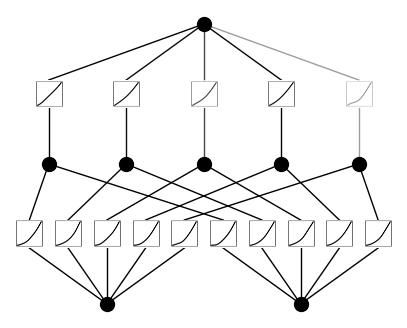

In [5]:
model(dataset['train_input']);
model.plot(beta=100)

#### Train KAN

Uses the LBFGS optimizer for 20 steps with sparsity regularization


In [6]:
model.train(dataset, opt="LBFGS", steps=20, lamb=0.01, lamb_entropy=10.);

train loss: 1.41e-01 | test loss: 1.47e-01 | reg: 2.71e+01 : 100%|██| 20/20 [00:11<00:00,  1.74it/s]


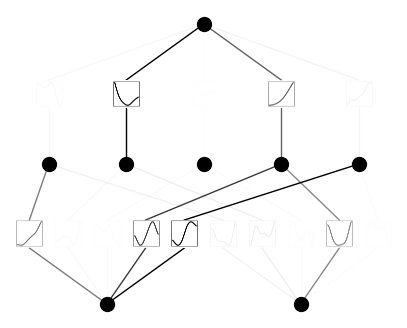

In [7]:
model.plot()

#### Prune KAN and replot (keep original shape)

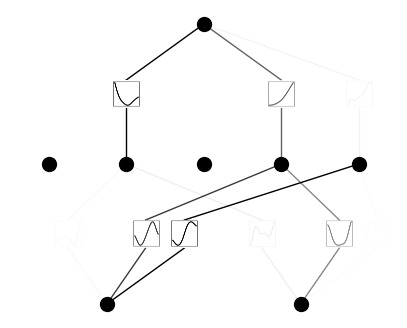

In [8]:
model.prune()
model.plot(mask=True)

#### Prune KAN and replot (get a smaller shape)

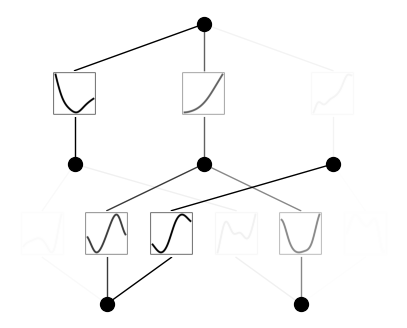

In [9]:
model = model.prune()
model(dataset['train_input'])
model.plot()

#### Continue training
Remember that KAN allows us to do continual training!

*Question: How have the splines changed after further training?*

In [10]:
model.train(dataset, opt="LBFGS", steps=50);

train loss: 2.53e-03 | test loss: 2.58e-03 | reg: 8.51e+00 : 100%|██| 50/50 [00:16<00:00,  2.94it/s]


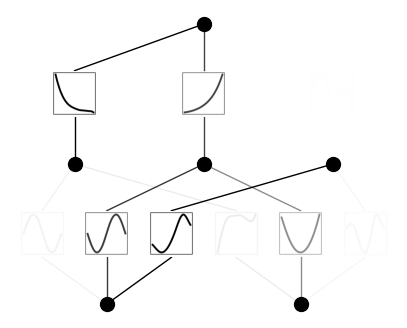

In [11]:
model.plot()

#### Set activation functions to be symbolic

We can either do this manually or automatically using the pykan library

*Try it yourself: try manual mode. How do the outputs differ from using the automated tooling?*

In [12]:
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,0,'sin');
    model.fix_symbolic(0,1,0,'x^2');
    model.fix_symbolic(1,0,0,'exp');
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    model.auto_symbolic(lib=lib)

fixing (0,0,0) with sin, r2=0.9994918704032898
fixing (0,0,1) with sin, r2=0.9999306797981262
fixing (0,0,2) with sin, r2=0.990466296672821
fixing (0,1,0) with tanh, r2=0.9603661298751831
fixing (0,1,1) with x^2, r2=0.9993442296981812
fixing (0,1,2) with sin, r2=0.9395317435264587
fixing (1,0,0) with tanh, r2=0.9981992244720459
fixing (1,1,0) with exp, r2=0.999995231628418
fixing (1,2,0) with log, r2=0.6053146123886108


#### Keep training!

In [13]:
model.train(dataset, opt="LBFGS", steps=50);

train loss: 1.67e-05 | test loss: 1.69e-05 | reg: 3.87e+01 : 100%|██| 50/50 [00:07<00:00,  6.94it/s]


#### Get the symbolic formula

In [14]:
model.symbolic_formula()[0][0]

1.0*exp(1.0*x_2**2 + 1.0*sin(3.14*x_1)) - 2.39*tanh(0.08*sin(3.17*x_1 + 9.41) - 0.05*tanh(4.49*x_2 + 3.72) + 4.53) + 2.39